# Playground

In [55]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling')
%cd /content/gdrive/MyDrive/generative-models-for-phenotypic-profiling
%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling


'/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling'

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset


from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [57]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [58]:
constant_seed()

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [69]:
#data_root = "G:/My Drive/generative-models-for-phenotypic-profiling/data/New_two_multicells_two_moas\"
data_root = "data/mix_from_all/"
#data_root = "data/two_multicells_two_moas/"
metadata_all = read_metadata(data_root + "metadata.csv")

mapping = get_MOA_mappings(metadata_all)

metadata = read_metadata(data_root + "metadata.csv")

metadata = shuffle_metadata(metadata)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]
images = load_images(image_paths)

In [93]:
metadata.shape

(1150, 19)

In [94]:
images.shape

torch.Size([1150, 3, 68, 68])

In [96]:
metadata.moa.unique()

array(['DNA replication', 'Aurora kinase inhibitors', 'DNA damage',
       'Microtubule stabilizers', 'Microtubule destabilizers', 'DMSO',
       'Cholesterol-lowering', 'Kinase inhibitors', 'Actin disruptors',
       'Eg5 inhibitors', 'Epithelial', 'Protein degradation',
       'Protein synthesis'], dtype=object)

In [209]:
#metadata_subset = metadata.loc[metadata['moa'] == 'Microtubule stabilizers']
#metadata_subset_small = metadata_subset.sample(frac=1).drop_duplicates(['Image_Metadata_Concentration']).sort_values(by=['Image_Metadata_Concentration']) this works!

metadata_subset = metadata.loc[(metadata['TableNumber'] == 9) & (metadata['moa'] == 'Cholesterol-lowering')]
metadata_subset_small = metadata_subset.sample(frac=1).drop_duplicates(['Image_Metadata_Concentration']) #.sort_values(by=['Image_Metadata_Concentration'])

In [210]:
metadata_subset_small.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
365,475832,3591,Week9_090907_D04_s1_w133946D18-DCB1-4A8A-B66A-...,1,Week9_090907_D04_s1_w133946D18-DCB1-4A8A-B66A-...,9,2969,Week9_090907_D04_s1_w133946D18-DCB1-4A8A-B66A-...,Week9_39282,Week9_090907_D04_s1_w261203E65-A8FB-42CF-9E53-...,Week9_39282,Week9_090907_D04_s1_w44845EAAD-331F-4698-8F17-...,Week9_39282,Week9_39282,D04,1,simvastatin,6.0,Cholesterol-lowering
66,475763,3581,Week9_090907_D03_s1_w1E7982D20-6285-4ABD-99C2-...,4,Week9_090907_D03_s1_w1E7982D20-6285-4ABD-99C2-...,9,2965,Week9_090907_D03_s1_w1E7982D20-6285-4ABD-99C2-...,Week9_39282,Week9_090907_D03_s1_w2E2DCFD07-C816-4838-A20C-...,Week9_39282,Week9_090907_D03_s1_w4BFD56527-7A9A-4BEB-9620-...,Week9_39282,Week9_39282,D03,1,simvastatin,20.0,Cholesterol-lowering
522,476138,3605,Week9_090907_D05_s1_w1EEC0CCCB-89B7-489F-9E5F-...,3,Week9_090907_D05_s1_w1EEC0CCCB-89B7-489F-9E5F-...,9,2973,Week9_090907_D05_s1_w1EEC0CCCB-89B7-489F-9E5F-...,Week9_39282,Week9_090907_D05_s1_w2E29C9C3C-B744-4A0A-A090-...,Week9_39282,Week9_090907_D05_s1_w4FC6312B1-D48B-4FDE-89FF-...,Week9_39282,Week9_39282,D05,1,simvastatin,2.0,Cholesterol-lowering
793,457941,3686,Week9_090907_E06_s1_w163684C94-A72B-4793-BA59-...,4,Week9_090907_E06_s1_w163684C94-A72B-4793-BA59-...,9,137,Week9_090907_E06_s1_w163684C94-A72B-4793-BA59-...,Week9_39206,Week9_090907_E06_s1_w27330A57E-C0CF-49BE-BE3A-...,Week9_39206,Week9_090907_E06_s1_w425F7651C-031F-43E5-BA4C-...,Week9_39206,Week9_39206,E06,1,mevinolin/lovastatin,1.5,Cholesterol-lowering
872,457634,3674,Week9_090907_E05_s1_w163C4CC50-9666-4A88-BE51-...,1,Week9_090907_E05_s1_w163C4CC50-9666-4A88-BE51-...,9,133,Week9_090907_E05_s1_w163C4CC50-9666-4A88-BE51-...,Week9_39206,Week9_090907_E05_s1_w2625B2A51-637D-4E4D-A113-...,Week9_39206,Week9_090907_E05_s1_w4B3CCC949-7812-4640-8A54-...,Week9_39206,Week9_39206,E05,1,mevinolin/lovastatin,5.0,Cholesterol-lowering


In [195]:
metadata_subset_small.index

Int64Index([1061, 925, 964, 6, 612, 197], dtype='int64')

In [196]:
images_tuple = ()
for i in metadata_subset_small.index:
    idx = str(i)
    images_tuple = images_tuple + (images[i],)

In [197]:
images_subset_small = torch.stack(images_tuple) #, dim=0)

In [204]:
normalize_channels_inplace(images_subset_small)


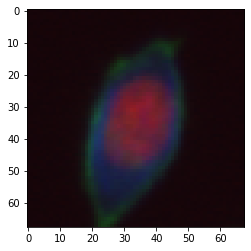

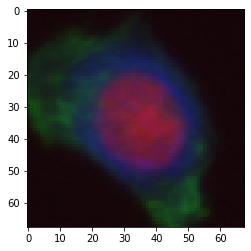

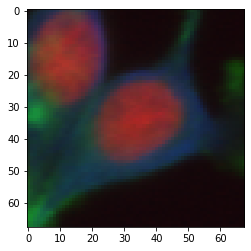

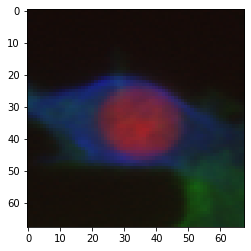

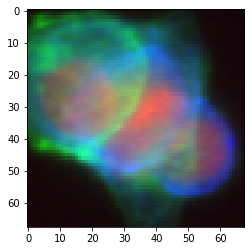

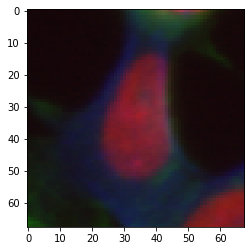

In [206]:
for i in images_subset_small:
  plot_image(i)